Step 1: Importing libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

In [7]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ------------- -------------------------- 3.1/9.6 MB 37.7 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.6 MB 11.8 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.6 MB 11.8 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 8.4 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.6 MB 7.6 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.6 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 6.7 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 

In [2]:
!pip install scipy

   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   --- ------------------------------------ 3.4/38.5 MB 40.3 MB/s eta 0:00:01
   ---- ----------------------------------- 4.7/38.5 MB 11.1 MB/s eta 0:00:04
   ----- ---------------------------------- 5.0/38.5 MB 11.5 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/38.5 MB 7.0 MB/s eta 0:00:05
   ------ --------------------------------- 6.6/38.5 MB 6.2 MB/s eta 0:00:06
   -------- ------------------------------- 7.9/38.5 MB 6.1 MB/s eta 0:00:06
   --------- ------------------------------ 9.2/38.5 MB 6.3 MB/s eta 0:00:05
   ---------- ----------------------------- 10.0/38.5 MB 5.9 MB/s eta 0:00:05
   ----------- ---------------------------- 10.7/38.5 MB 5.7 MB/s eta 0:00:05
   ------------ --------------------------- 12.1/38.5 MB 5.7 MB/s eta 0:00:05
   ------------- -------------------------- 13.4/38.5 MB 5.7 MB/s eta 0:00:05
   -------------- ------------------------- 14.2/38.5 MB 5.6 MB/s eta 0:00:0

Step 2: Load the Data and set Index

In [12]:
# load the data
df = pd.read_csv("LoanData.csv")
df.head()

,LoanId,NewCreditCustomer,LoanDate,VerificationType,Age,Gender,Country,AppliedAmount,Amount,Interest,...,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,Rating,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,False,2022-09-09,By Bank Statement,27,Female,EE,3189.0,3189.0,35.48,...,UpTo5Years,Other,900.0,0,0.00,0,D,1.0,3402.0,0.0
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,False,2023-05-19,By Bank Statement,35,Female,FI,4146.0,4146.0,19.86,...,UpTo5Years,Owner,3100.0,0,0.00,0,B,1.0,518.0,0.0
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,False,2024-02-03,By Bank Statement,23,Male,EE,531.0,531.0,19.52,...,UpTo5Years,TenantFurnished,1700.0,0,0.00,0,B,3.0,1593.0,0.0
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,False,2016-03-23,By Bank Statement,53,Female,EE,2125.0,2125.0,20.97,...,MoreThan5Years,Owner,354.0,8,485.09,6,C,1.0,500.0,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,False,2023-09-26,By Bank Statement,43,Male,FI,414.0,414.0,19.89,...,Other,TenantFurnished,1200.0,0,0.00,0,D,5.0,11198.0,0.0


In [11]:
# set the "LoanId" column as index
df.set_index("LoanId", inplace=True )
#check the index
df.index.name

'LoanId'

To recommend loan offers, we need to understand the loan amounts and ratings. we'll get a rough idea of the interest rates being paid.

In [13]:
# find the sample mean and std of the "Interest" column
interest_mean = df["Interest"].mean()
interest_std = df["Interest"].std()

# find the number of borrowers that received a smaller "Amount" than they asked for ("AppliedAmount")
num_less_amount = (df["Amount"] < df["AppliedAmount"]).sum()

# find the proportion of loan ratings
rating_proportion = (df["Rating"].value_counts())/len(df)


In [14]:
# print the results
print("Interest rate mean:", round(interest_mean, 2))
print("Interest rate standard deviation:", round(interest_std,2))
print("Number of borrowers that received less money than they asked for:", num_less_amount)
print("Proportion of loan ratings:\n", rating_proportion.sort_index())

Interest rate mean: 27.29
Interest rate standard deviation: 18.03
Number of borrowers that received less money than they asked for: 10543
Proportion of loan ratings:
 Rating
A     0.043291
AA    0.024826
B     0.179124
C     0.317741
D     0.206457
E     0.115707
F     0.074443
HR    0.038411
Name: count, dtype: float64


Step 3: Identifying High-Risk Customers: 

Now, We  want to identify these customers and be able to add a flag to their loans. considering borrowers to have less job stability if they have been on the current job for less than 1 year (including those in the trial period). In this scenario, a loan-to-rate ratio above 0.35 is assumed to be risky.

In [15]:
# create the column "DebtToIncome" 
df["DebtToIncome"] = df["Amount"] / df["IncomeTotal"]

# create a new column "IsRisky" that is True if the loan is risky
df["IsRisky"] = (df["DebtToIncome"] >= 0.35) & (df["EmploymentDurationCurrentEmployer"].isin(["TrialPeriod", "UpTo1Year"]))

# calculate the proportion of risky loans
risky_proportion = df["IsRisky"].sum() / len(df["IsRisky"])

# calculate the mean interest rate of the risky loans
mean_interest_risky = df[df["IsRisky"]]["Interest"].mean()

# calculate the mean interest rate of the non-risky loans
mean_interest_non_risky = df[~df["IsRisky"]]["Interest"].mean()

High-Risk Customers:

Customers with a high debt-to-income ratio and less job stability may have more difficulty repaying loans, making them riskier.

In [17]:
# print the results
print("Risky loans proportion:", round(risky_proportion, 4))
print("Mean interest rate of risky loans:", round(mean_interest_risky, 4))
print("Mean interest rate of non-risky loans:", round(mean_interest_non_risky, 4))

Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899


Step 4: Understanding different customer profiles:

understanding customer profiles will allow us to identify patterns. we want to understand how different factors of the borrowers influence loan applications.

Visualization of different profiles:

To identify the different profiles, we need some visualization to uncover actionable patterns for tailoring loan offers.

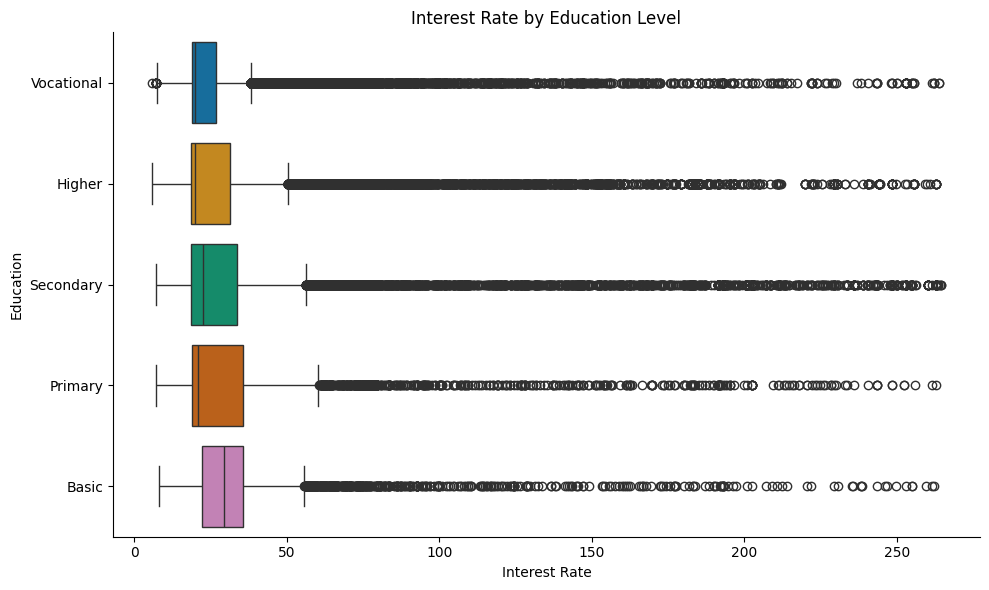

In [18]:
# create the figure with size (10,6)
plt.figure(figsize=(10,6))

# create the interest rate by segmentation plot
boxplot_ax = sns.boxplot(df,x="Interest", y="Education", hue="Education",palette="colorblind")

# set the x-axis label
plt.xlabel("Interest Rate")

# set the title
plt.title("Interest Rate by Education Level")

# despine the plot
sns.despine(top=True, right=True)


plt.tight_layout()
plt.show()

Scatter plots and correlation:

we also want to investigate the relationship between certain numerical features and the interest rate. For that, we decide to use scatter plots, along with the correlation between features

Correlation between Interest Rate and LoanDuration:
-0.0106
Correlation between Interest Rate and IncomeTotal:
-0.0122
Correlation between Interest Rate and AmountOfPreviousLoansBeforeLoan:
-0.175
Correlation between Interest Rate and DebtToIncome:
-0.0053


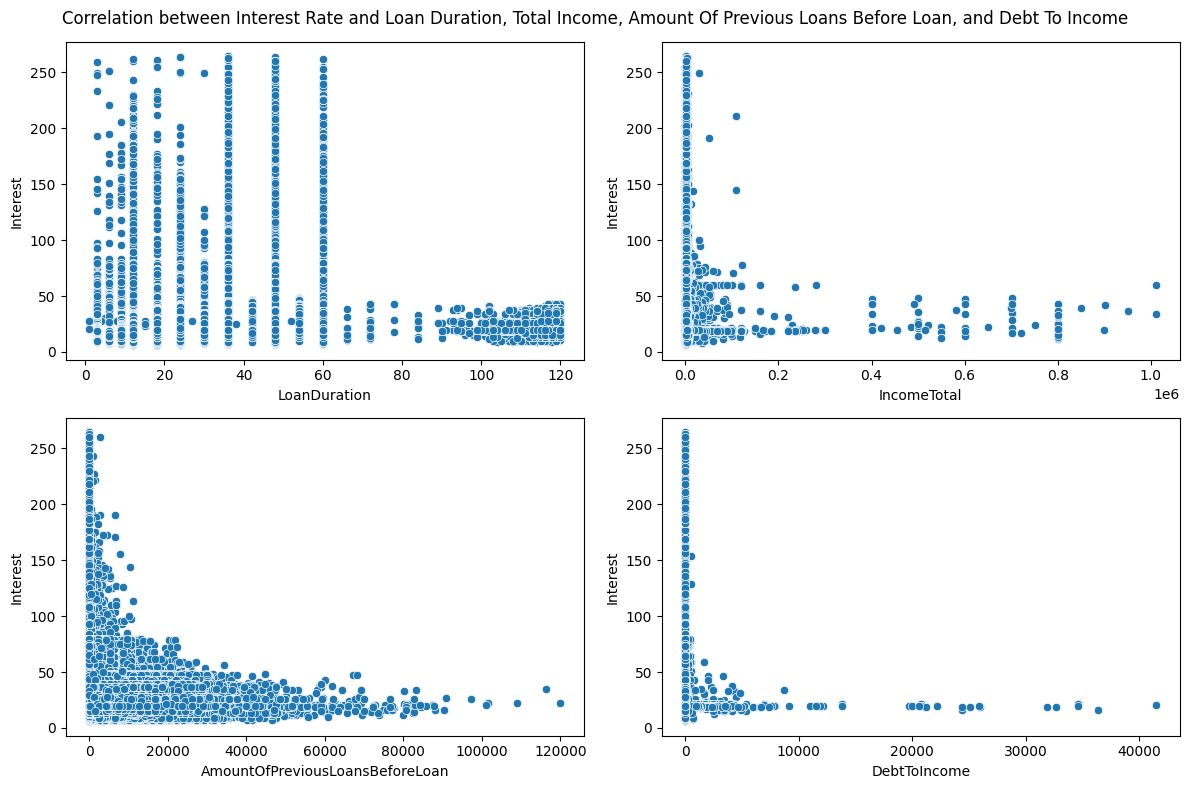

In [19]:
scatterplot_fig = plt.figure(figsize=(12, 8))

# create a list to store the correlation values
correlation = []

# create a list of segmentation columns
corr_columns = ["LoanDuration", "IncomeTotal", "AmountOfPreviousLoansBeforeLoan", "DebtToIncome"]

# iterate over the values 1-4 (one for each subplot)
for i in range(1,5):

    # get the column name. Remember subtract 1 from i to match the list's indexing
    column_name = corr_columns[i-1]

    # create the subplot. Remember the arguments are (rows, columns, index)
    plt.subplot(2,2,i)

    # create scatter plot
    sns.scatterplot(df, x=column_name, y="Interest")

    # calculate the correlation between the column and the interest rate
    corr = df["Interest"].corr(df[column_name])

    # append the correlation value to the list
    correlation.append(corr)

    # print the results
    print("Correlation between Interest Rate and " + column_name+ ":\n"+ str(round(corr,4))) 

# set the general title
plt.suptitle("Correlation between Interest Rate and Loan Duration, Total Income, Amount Of Previous Loans Before Loan, and Debt To Income")

### END CODE HERE ###

plt.tight_layout()
plt.show()

Applied and Received Amounts:

we noticed that there are two similar columns, "AppliedAmount" and "Amount", in the dataset. This implies that sometimes borrowers get loaned a different amount than what they asked for.


Confidence Intervals: 

If more than 5% of loans are approved for less than requested, the team may need to revise how loan amounts are communicated to applicants. we estimate this proportion using a confidence interval to support our recommendation.

In [20]:
# get the number of samples where "AppliedAmount" differs from the requested
# "Amount"
num_differences = (df["Amount"] < df["AppliedAmount"]).sum()

# get the total number of samples
n = len(df["Amount"])

# calculate the sample proportion
phat = num_differences/n

# calculate the standard error for proportions
se = sqrt(phat * (1 - phat) / n)

# build the confidence interval
confidence_interval = stats.norm.interval(0.95, loc=phat, scale=se)

In [24]:
# print the results
print("The 95% confidence interval is", confidence_interval)

The 95% confidence interval is (np.float64(0.02698232853687249), np.float64(0.028017645379482474))


Step 5: Modelling the Interest Rate:

To make personalized loan offers, we decide to go one step further in our analysis and build a model to predict interest rates using different customer features. This will help us in both being able to predict interest rates for new customers, and observe which features are actually statistically significant in determining the interest rates.




Simple Linear Regression: 

To get our model going we begin creating a simple linear regression. Based on the correlation analysis we did before, a good candidate for the independent variable is "AmountOfPreviousLoansBeforeLoan", which presented the strongest correlation with the target variable "Interest".

In [25]:
#Training Our Linear Regression Model

# prepare predictors. do not forget to add the constant term
X_simple = sm.add_constant(df["AmountOfPreviousLoansBeforeLoan"])

# select the dependent variable
Y_simple = df["Interest"]

# build the model
model_simple = sm.OLS(Y_simple,X_simple)

# fit the model
results_simple = model_simple.fit()

# Print the results summary
print(results_simple.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:29:03   Log-Likelihood:            -1.6468e+06
No. Observations:              383382   AIC:                         3.294e+06
Df Residuals:                  383380   BIC:                         3.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

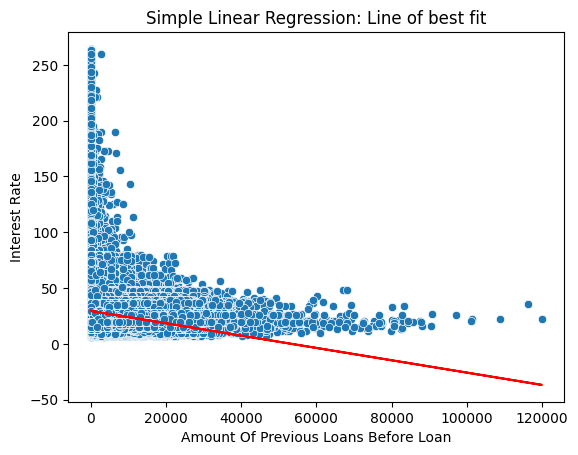

In [26]:
plt.figure()
sns.scatterplot(data=df, x="AmountOfPreviousLoansBeforeLoan", y="Interest")
plt.plot(df["AmountOfPreviousLoansBeforeLoan"], results_simple.predict(X_simple), color="red")
plt.title("Simple Linear Regression: Line of best fit")
plt.xlabel("Amount Of Previous Loans Before Loan")
plt.ylabel("Interest Rate")
plt.show()

Building a More Complex Linear Regression Model:

Since predicting the interest rate using a single variable didn’t yield strong results, we further decide to take a more comprehensive approach. This time, we’ll build a more complex model that includes multiple variables—possibly even some categorical ones.

In [27]:
# define a list with the column names you want to use as predictors
# include numerical and categorical variables
predictors = ["Education","Rating"]

categorical = ["Education","Rating"]

# create the predictors dataframe. do not forget to add the constant term
X = sm.add_constant(pd.get_dummies(df[predictors], columns=categorical, drop_first=True, dtype=int))

# create the target variable
Y = df["Interest"]

# create the model
model = sm.OLS(Y,X)

# fit the model
results = model.fit()

### END CODE HERE ###

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                 5.310e+04
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:34:18   Log-Likelihood:            -1.4754e+06
No. Observations:              383382   AIC:                         2.951e+06
Df Residuals:                  383370   BIC:                         2.951e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.1571 